In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import numpy as np
import pickle
import matplotlib.cm as cm
import matplotlib.axes as am
import matplotlib.pyplot as plt
%matplotlib widget

import dimod
import dwave
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
import dwave_networkx as dnx
import minorminer

from src.particle_funcs import distance_matrix as distance_matrix
from src.particle_funcs import io as particles_io
import src.leap_funcs.qubo.q_matrix as q_matrix

from src import leap_funcs as leap_funcs
from src.leap_funcs import embedding_quality
from src.leap_funcs.qubo import parameterstudy

from src import h5py_funcs
from src.h5py_funcs import inspections, discoveries, init_custom_getstates, io, parameterstudy_using_info_file

no cupy available, imported numpy as usual
Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.


In [2]:
study_name = 'sub_2'
info_file_name = r'study_params_small.h5'
study_name = 'sub_3'
study_name = 'sub_4'

study_subs = ['', '_2']
#study_subs = ['']

info_file_name = [r'study_params_sub4' + sub + '.h5' for sub in study_subs]


study_folder_path = [pathlib.Path.cwd().joinpath('01_out\\'+study_name+sub) for sub in study_subs]

info_file_name_path = [pathlib.Path.joinpath(sfp, ifn) for sfp, ifn in zip(study_folder_path, info_file_name)]
samples_folder_name = r'samples'
samples_folder_name_path = [pathlib.Path.joinpath(sfp, samples_folder_name) for sfp in study_folder_path]
print(str(info_file_name_path[0])[-3:])
assert np.array([i.exists() for i in info_file_name_path]).all(), f'Info file does not exist. Check info_file_name_path ({info_file_name_path})'
info_file_name_path

.h5


[WindowsPath('c:/Users/oahre/RWTH/OneDrive_Students_RWTH/RWTH/Simulation_Sciences/Masterthesis/04_Code/Quantum_Annealing_for_Particle_Matching/00_tests/01_out/sub_4/study_params_sub4.h5'),
 WindowsPath('c:/Users/oahre/RWTH/OneDrive_Students_RWTH/RWTH/Simulation_Sciences/Masterthesis/04_Code/Quantum_Annealing_for_Particle_Matching/00_tests/01_out/sub_4_2/study_params_sub4_2.h5')]

In [3]:
dict_infos_read = {i:h5py_funcs.inspections.read_info_file_to_dict(info_file_name_path=ifp, infoset_name = 'info')  for i,ifp in enumerate(info_file_name_path)}
#dddddd = dict_infos_read.copy()

dict_info_read = {}
#for key in reversed(dict_infos_read.keys()): #reversed to make sure info from initial study_file is contained as a|=b priorizes b
#    dict_info_read = dict_info_read | dddddd[key]

for i,ifp in enumerate(info_file_name_path):
    dict_info_read.update(h5py_funcs.inspections.read_info_file_to_dict(info_file_name_path=ifp, infoset_name = 'info'))

#dict_info_read


#orig:
#dict_info_read = h5py_funcs.inspections.read_info_file_to_dict(info_file_name_path=info_file_name_path, infoset_name = 'info')
#dict_info_read.keys()

##########
#
# The following test fails, because comparing dicts throws an error (below) when arrays are encountered, thats why it is left to the user to make sure the subs are compatible with the main study.
# "The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()" 
#
#########
#if len(info_file_name_path)>1:
#    for i in range(len(info_file_name_path)):
#        for key, value in dict_infos_read[0].items():
#            if key=='time_history': continue
#            else:
#                print(key)
#                if isinstance(value, np.ndarray):
#                    assert (value == dict_infos_read[i][key]).all(), print(value, dict_infos_read[i][key])
#                else:
#                    try: value == dict_infos_read[i][key]
#                    except Exception as e:
#                        print(e)
#                        print(value)
#                        print(dict_infos_read[i][key])

In [4]:
#print(dict_infos_read[0]['time_history'])
for i in range(len(dict_infos_read)):
    _tmp = []
    for key, value in dict_infos_read[i]['time_history'].items():
        if key == 'attrs':
            continue
        else:
            if not value['attrs']['finished']:
                _tmp.append(key)
    print(len(_tmp), _tmp)
del _tmp

257 ['zz_3643551030', 'zz_1173800121', 'zz_7696362792', 'zz_5933763981', 'zz_4836504423', 'zz_6457257549', 'zz_3755824370', 'zz_3421451199', 'zz_2256687642', 'zz_0496529817', 'zz_7874613152', 'zz_9284556575', 'zz_7690011195', 'zz_8788093134', 'zz_8789536424', 'zz_9663321771', 'zz_5740185539', 'zz_0227732391', 'zz_9895879121', 'zz_7470996840', 'zz_3012426378', 'zz_6913992781', 'zz_6709365046', 'zz_7496619083', 'zz_1928518788', 'zz_5466520901', 'zz_1459121781', 'zz_7404369298', 'zz_1673726294', 'zz_7755647775', 'zz_0635347287', 'zz_1645343449', 'zz_8431075723', 'zz_2010481619', 'zz_5262836756', 'zz_1501834379', 'zz_9359358999', 'zz_5526450909', 'zz_5960526729', 'zz_4112334474', 'zz_6384572677', 'zz_3956019518', 'zz_5604545551', 'zz_3998398143', 'zz_1272676174', 'zz_8217193333', 'zz_2973216165', 'zz_4428879168', 'zz_9564676887', 'zz_8087794936', 'zz_1366713732', 'zz_9854146520', 'zz_9637482686', 'zz_7637393284', 'zz_7664471719', 'zz_2162100703', 'zz_7062251890', 'zz_3094898930', 'zz_10439

In [5]:
list_studies = list(dict_info_read['time_history'].keys())
list_studies.remove('attrs')
print(len(list_studies), list_studies)

512 ['zz_0594500236', 'zz_8399935511', 'zz_8254472835', 'zz_5764679840', 'zz_0210405625', 'zz_9579793783', 'zz_9568089288', 'zz_0562826232', 'zz_0922653251', 'zz_2434077918', 'zz_2871450148', 'zz_8798000343', 'zz_9357211953', 'zz_6580697660', 'zz_6408592024', 'zz_8383268435', 'zz_0497928876', 'zz_6726194657', 'zz_6629375788', 'zz_4041835465', 'zz_9144036899', 'zz_7631550656', 'zz_2038950416', 'zz_1161068603', 'zz_7253153800', 'zz_2927355622', 'zz_6809108860', 'zz_1638988001', 'zz_8677621521', 'zz_1426986117', 'zz_6519846298', 'zz_6753648971', 'zz_7113932168', 'zz_8093166368', 'zz_3595284705', 'zz_8115207891', 'zz_7406910559', 'zz_0470282487', 'zz_6072268519', 'zz_2751579513', 'zz_6267210246', 'zz_9120108892', 'zz_9283105305', 'zz_6570843060', 'zz_3740505924', 'zz_0859115108', 'zz_9068195746', 'zz_5986609357', 'zz_2282652989', 'zz_4724076768', 'zz_6684243645', 'zz_0760343573', 'zz_6688397866', 'zz_1357332004', 'zz_6262717099', 'zz_4561369957', 'zz_7511325543', 'zz_5152156763', 'zz_16446

In [6]:
print(dict_info_read['time_history']['zz_7293366434']['data'][2].decode('utf-8')[:4] == '2024')
print(dict_info_read['time_history']['zz_7293366434']['attrs']['finished'])

True
True


In [7]:
for stud in list_studies:
    if (not dict_info_read['time_history'][stud]['attrs']['finished'])\
        and (dict_info_read['time_history'][stud]['data'][2].decode('utf-8')[:4] == '2024'):
        print('here 1', stud)
    elif dict_info_read['time_history'][stud]['attrs']['finished']\
        and (dict_info_read['time_history'][stud]['data'][2].decode('utf-8')[:4] != '2024'):
        print('here 1_2', stud)
    elif dict_info_read['time_history'][stud]['attrs']['finished']\
        and (dict_info_read['time_history'][stud]['data'][2].decode('utf-8')[:4] == '2024'):
        #print('here 2')
        continue
    else:
        print('here else', stud)
        for key, value in dict_infos_read.items():
            if '2024' == value['time_history'][stud]['data'][2].decode('utf-8')[:4]:
                dict_info_read['time_history'][stud]['data'][1] = (value['time_history'][stud]['data'][1]+'.'.encode('utf-8'))[:-1]
                dict_info_read['time_history'][stud]['data'][2] = (value['time_history'][stud]['data'][2]+'.'.encode('utf-8'))[:-1]
                dict_info_read['time_history'][stud]['attrs']['finished'] = True


In [8]:
for stud in list_studies:
    if not dict_info_read['time_history'][stud]['attrs']['finished']:
        print(stud, dict_info_read['time_history'][stud]['data'])

In [9]:
print(dict_info_read['study'])
study_read = dict_info_read['study']['data']
study_read.dtype.names
est_runts = study_read['sets']['estimated_runtime']
cum_est_runts = np.sum(est_runts)
print(est_runts)
print('cummulative estimated runtime for 1000 samples each is [h]:', cum_est_runts/3600)
del study_read, est_runts, cum_est_runts


{'attrs': {}, 'data': array([((453.16081486,  979.03419752, 2776.63309127, 3.36475448), b'zz_0594500236'),
       ((442.39189413,  979.03419752, 2776.63309127, 3.35398556), b'zz_8399935511'),
       ((453.16081486, 3440.09693246, 2776.63309127, 3.36721555), b'zz_8254472835'),
       ((453.16081486,  979.03419752,  588.32992986, 1.17645132), b'zz_5764679840'),
       ((453.16081486, 3440.09693246,  588.32992986, 1.17891239), b'zz_0210405625'),
       ((442.39189413,  979.03419752,  588.32992986, 1.1656824 ), b'zz_9579793783'),
       ((442.39189413, 3440.09693246, 2776.63309127, 3.35644663), b'zz_9568089288'),
       ((442.39189413, 3440.09693246,  588.32992986, 1.16814347), b'zz_0562826232'),
       ((518.32459855, 4388.81576527, 1384.37397406, 2.04106893), b'zz_0922653251'),
       ((960.72866133, 4388.81576527, 1384.37397406, 2.483473  ), b'zz_2434077918'),
       ((518.32459855, 1326.67769212, 1384.37397406, 2.03800679), b'zz_2871450148'),
       ((518.32459855, 4388.81576527, 3023.

In [10]:
array_identifiers, started_psets, finished_psets = h5py_funcs.inspections.extract_identifiers(dict_info_read = dict_info_read)

print(started_psets)
print(finished_psets)
print('{p1}/{p2} p_sets have been started, \n {p3}/{p2} p_sets have been finished'.format(p1=len(started_psets), p2=array_identifiers.shape[0], p3=len(finished_psets)))

list_array_identifiers = []; list_started_psets = []; list_finished_psets = []
appenders = [list_array_identifiers, list_started_psets, list_finished_psets]
for d in dict_infos_read.values():
    appendees = h5py_funcs.inspections.extract_identifiers(dict_info_read = d)
    print(len(appendees[0]), len(appendees[1]), len(appendees[2]))
    assert (array_identifiers==appendees[0]).all()
    list_array_identifiers.append(appendees[0])
    if len(list_started_psets) > 0:
        print('here if')
        list_started_psets.append([ap for ap in appendees[1] if not ap in list_started_psets[0]])
        list_finished_psets.append([ap for ap in appendees[2] if not ap in list_finished_psets[0]])
    else:
        print('here else')
        list_started_psets.append(appendees[1])
        list_finished_psets.append(appendees[2])

print(list_started_psets)
print(list_finished_psets)
print('{p1}/{p2} p_sets have been started, \n {p3}/{p2} p_sets have been finished'.\
      format(p1=[len(l) for l in list_started_psets], p2=[len(l) for l in list_array_identifiers], p3=[len(l) for l in list_finished_psets]))

[b'zz_0594500236', b'zz_8399935511', b'zz_8254472835', b'zz_5764679840', b'zz_0210405625', b'zz_9579793783', b'zz_9568089288', b'zz_0562826232', b'zz_0922653251', b'zz_2434077918', b'zz_2871450148', b'zz_8798000343', b'zz_9357211953', b'zz_6580697660', b'zz_6408592024', b'zz_8383268435', b'zz_0497928876', b'zz_6726194657', b'zz_6629375788', b'zz_4041835465', b'zz_9144036899', b'zz_7631550656', b'zz_2038950416', b'zz_1161068603', b'zz_7253153800', b'zz_2927355622', b'zz_6809108860', b'zz_1638988001', b'zz_8677621521', b'zz_1426986117', b'zz_6519846298', b'zz_6753648971', b'zz_7113932168', b'zz_8093166368', b'zz_3595284705', b'zz_8115207891', b'zz_7406910559', b'zz_0470282487', b'zz_6072268519', b'zz_2751579513', b'zz_6267210246', b'zz_9120108892', b'zz_9283105305', b'zz_6570843060', b'zz_3740505924', b'zz_0859115108', b'zz_9068195746', b'zz_5986609357', b'zz_2282652989', b'zz_4724076768', b'zz_6684243645', b'zz_0760343573', b'zz_6688397866', b'zz_1357332004', b'zz_6262717099', b'zz_4561

In [11]:
is_read_from_sample_data = False

In [12]:
dict_for_df = {}
if is_read_from_sample_data:
    for sfnp, ids in zip(samples_folder_name_path,list_finished_psets):
        print('reading from', sfnp)
        dict_for_df |= h5py_funcs.inspections.read_answers_to_dict(\
            samples_folder_name_path=sfnp\
            , array_identifiers=np.array(ids))#[::25]
    print(dict_for_df.__sizeof__()) # size in memory in bytes
    print(len(dict_for_df)) # number of keys in dict
    with open(f'01_out\\dict_for_df_{study_name}.txt', 'wb') as f:
        pickle.dump(dict_for_df, f, protocol=5)
    del dict_for_df


In [13]:
if not is_read_from_sample_data:
    with open(f'01_out\\dict_for_df_{study_name}.txt', 'rb') as f:
        dict_for_df = pickle.load(f)

In [14]:
import ast
import dwave.samplers

num_particles = 5
qubo = dict_info_read['qubos'][f'{num_particles}_{num_particles}']

#sim_annealing_sample = dimod.samplers.ExactSolver().sample_qubo(
#    {ast.literal_eval(key): value['data'] for key, value in qubo.items()})
sim_annealing_sample = dwave.samplers.SimulatedAnnealingSampler().sample_qubo(
    {ast.literal_eval(key): value['data'] for key, value in qubo.items()},
    num_reads=10000)
sim_annealing_sample = sim_annealing_sample.aggregate() # accumulates number of occurences

In [15]:
type(sim_annealing_sample)

dimod.sampleset.SampleSet

In [16]:
exact_sol = sim_annealing_sample.record
exact_sol.sort(order='energy')
exact_sol

rec.array([([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], -9.90205303, 127),
           ([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], -9.89043746,  81),
           ([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], -9.88628398, 112),
           ([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], -9.88406401,  89),
           ([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], -9.88305524,  95),
           ([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0], -9.88083528,  94),
           ([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], -9.88065613,  99),
           ([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], -9.87897741,  93),
           ([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], -9.87143967,  92),
           ([1, 0, 0, 0, 0, 

In [38]:
n_samples_to_compare = 3
n_exact_sols_to_compare = 3
#colour_label = 'fraction_samples_matched_3_samps_3_sols'
colour_label = 'fraction_samples_is_found_best'
dir_name_path_plots = './01_out/'
is_train_gp = False
training_iterations = 5 # only required if is_train_gp==True

In [39]:
success_dict = h5py_funcs.inspections.extract_success_dict(\
    dict_for_df = dict_for_df\
    , exact_sols = exact_sol\
    , n_samples_to_compare = n_samples_to_compare\
    , n_exact_sols_to_compare = n_exact_sols_to_compare)


for key in success_dict.keys():
    print(key, success_dict[key])

zz_7113932168 {'is_found_best': True, 'num_runs_is_found_best': 10, 'num_samples_is_found_best': 157, 'num_samples_is_found_best_per_run': [18, 15, 11, 24, 17, 23, 8, 15, 16, 10], 'is_found_best_per_run': [True, True, True, True, True, True, True, True, True, True], 'num_samples': 10000, 'num_runs': 10, 'num_subs_per_run': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'num_samples_per_run': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'num_samples_per_sub_per_run': [[333, 333, 334], [333, 333, 334], [333, 333, 334], [333, 333, 334], [333, 333, 334], [333, 333, 334], [333, 333, 334], [333, 333, 334], [333, 333, 334], [333, 333, 334]], 'num_matched': 89, 'num_matched_per_run': [9, 9, 9, 8, 9, 9, 9, 9, 9, 9], 'num_matched_per_sub_per_run': [[3, 3, 3], [3, 3, 3], [3, 3, 3], [2, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]], 'num_samples_matched': 326, 'num_samples_matched_per_run': [39, 38, 22, 42, 39, 35, 29, 30, 31, 21], 'num_samples_matched_per_sub_per_run'

In [40]:
#fig = h5py_funcs.inspections.return_bar_plot(\
#    success_dict = success_dict\
#    , n_samples_to_compare = n_samples_to_compare\
#    , n_exact_sols_to_compare = n_exact_sols_to_compare)



In [41]:
a = np.zeros((dict_info_read['study']['data'].shape[0],))
print(a)
print(dict_info_read['study']['data']['sets'].shape)
print(dict_info_read['study']['data']['sets'].dtype.isalignedstruct)
b = np.lib.recfunctions.rec_append_fields(dict_info_read['study']['data'], 'param 1', a)
print(b)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [42]:
print(b.dtype)

(numpy.record, [('sets', [('annealing_time', '<f8'), ('programming_thermalization', '<f8'), ('readout_thermalization', '<f8'), ('estimated_runtime', '<f8')]), ('identifiers', 'S13'), ('param 1', '<f8')])


In [43]:
dict_info_read['study']['data']['sets'].copy().view(dtype=np.float64, type=np.ndarray)

array([4.53160815e+02, 9.79034198e+02, 2.77663309e+03, ...,
       3.29688527e+02, 3.52739416e+02, 7.00308507e-01])

In [44]:
started_sets, study_matched_started_ids = h5py_funcs.inspections.extract_started_sets_from_success_dict(\
    success_dict = success_dict\
    , dict_info_read = dict_info_read)
print(started_sets)
print(study_matched_started_ids)
print(study_matched_started_ids.dtype)

[b'zz_7113932168', b'zz_0594500236', b'zz_8093166368', b'zz_3595284705', b'zz_8399935511', b'zz_8115207891', b'zz_8254472835', b'zz_7406910559', b'zz_5764679840', b'zz_0470282487', b'zz_0210405625', b'zz_6072268519', b'zz_9579793783', b'zz_9568089288', b'zz_2751579513', b'zz_6267210246', b'zz_0562826232', b'zz_0922653251', b'zz_9120108892', b'zz_2434077918', b'zz_9283105305', b'zz_2871450148', b'zz_6570843060', b'zz_8798000343', b'zz_3740505924', b'zz_9357211953', b'zz_0859115108', b'zz_6580697660', b'zz_9068195746', b'zz_6408592024', b'zz_5986609357', b'zz_8383268435', b'zz_0497928876', b'zz_2282652989', b'zz_6726194657', b'zz_6629375788', b'zz_4041835465', b'zz_4724076768', b'zz_9144036899', b'zz_6684243645', b'zz_0760343573', b'zz_6688397866', b'zz_7631550656', b'zz_1357332004', b'zz_2038950416', b'zz_1161068603', b'zz_6262717099', b'zz_7253153800', b'zz_4561369957', b'zz_7511325543', b'zz_2927355622', b'zz_5152156763', b'zz_6809108860', b'zz_1644681245', b'zz_1638988001', b'zz_0517

In [45]:
results_names = list(list(success_dict.values())[0].keys())
to_remove = ['is_found_best_per_run', 'num_subs_per_run', 'num_samples_per_run', 'num_samples_per_sub_per_run', 'num_matched_per_run'\
             , 'num_matched_per_sub_per_run', 'num_samples_matched_per_run', 'num_samples_matched_per_sub_per_run', 'submissions', 'num_samples_is_found_best_per_run']
for s in to_remove:
    results_names.remove(s)
print(results_names)

sampler_array,results_names, ids = h5py_funcs.inspections.generate_sampler_array_for_plots(\
    success_dict = success_dict\
    , results_names = results_names\
    , started_sets = started_sets\
    , study_matched_started_ids = study_matched_started_ids\
    , n_samples_to_compare = n_samples_to_compare\
    , n_exact_sols_to_compare = n_exact_sols_to_compare)

print(sampler_array.shape)
print(results_names)

['is_found_best', 'num_runs_is_found_best', 'num_samples_is_found_best', 'num_samples', 'num_runs', 'num_matched', 'num_samples_matched']
(512, 9)
['is_found_best', 'num_runs_is_found_best', 'num_samples_is_found_best', 'num_samples', 'num_runs', 'num_matched', 'num_samples_matched', 'fraction_samples_is_found_best', 'fraction_samples_matched_3_samps_3_sols']


In [46]:
import torch
import gpytorch

In [47]:
class MultitaskGPModel(gpytorch.models.ExactGP):
                def __init__(self, train_x, train_y, likelihood):
                    super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
                    self.mean_module = gpytorch.means.MultitaskMean(
                        gpytorch.means.ConstantMean(), num_tasks=sampler_array.shape[1]
                    )
                    self.covar_module = gpytorch.kernels.MultitaskKernel(
                        gpytorch.kernels.RBFKernel(), num_tasks=sampler_array.shape[1]
                    )

                def forward(self, x):
                    mean_x = self.mean_module(x)
                    covar_x = self.covar_module(x)
                    return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

            # Instantiate multi-task likelihood and GP model 
if study_name == 'sub_2':
    train_x = torch.tensor(study_matched_started_ids['sets'].view(np.float64).copy()).to(torch.float)
    test_x = torch.tensor(dict_info_read['study']['data']['sets'].view(np.float64).copy()).to(torch.float)
else:
    _tmp_train_dtype = study_matched_started_ids['sets'].dtype
    _tmp_test_dtype = dict_info_read['study']['data']['sets'].dtype
    _tmp_train_data = study_matched_started_ids['sets'].view((np.float64, len(_tmp_train_dtype.names))).copy()
    _tmp_test_data = dict_info_read['study']['data']['sets'].view((np.float64, len(_tmp_test_dtype.names))).copy()
    train_x = torch.tensor(_tmp_train_data).to(torch.float)
    test_x = torch.tensor(_tmp_test_data).to(torch.float)
    del(_tmp_train_dtype, _tmp_test_dtype, _tmp_train_data, _tmp_test_data)

train_y = torch.tensor(sampler_array).to(torch.float)

num_params_in_gp = train_x.shape[1]
num_params_out_gp = train_y.shape[1]

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=sampler_array.shape[1])
model = MultitaskGPModel(train_x, train_y, likelihood)

In [48]:
if not is_train_gp:
    print('is_train_gp =', is_train_gp, ' GP training is skipped')
    mean = None
    pass
else:
    # Switch to training mode
    model.train()
    likelihood.train()

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    # Train GP using training data
    print('Start training')
    print(training_iterations)
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        print('  Finished training iteration %i/%i' % (i + 1, training_iterations), 'loss:', loss.item())
    print('Finished training' + '\n')
    # Switch to evaluation mode, and probe trained GP using testing data
    model.eval()
    likelihood.eval()
    print('Start testing')
    with torch.no_grad():
        observed_model = model(test_x)
        print('  Testing: Finished evaluation')
        observed_pred = likelihood(observed_model)
        print('  Testing: Finished likelihood')
        mean = observed_pred.mean
        lower, upper = observed_pred.confidence_region()
    print('Finished testing' + '\n')

    assert mean.shape[1] == num_params_out_gp

is_train_gp = False  GP training is skipped


In [49]:
sampler_array.shape

(512, 9)

In [50]:
import importlib
importlib.reload(h5py_funcs.inspections)

<module 'src.h5py_funcs.inspections' from 'c:\\Users\\oahre\\RWTH\\OneDrive_Students_RWTH\\RWTH\\Simulation_Sciences\\Masterthesis\\04_Code\\Quantum_Annealing_for_Particle_Matching\\src\\h5py_funcs\\inspections.py'>

In [51]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
kwargs_pltrc = {'font_size':SMALL_SIZE\
                ,'axes_titlesize': SMALL_SIZE\
                ,'axes_labelsize': MEDIUM_SIZE\
                ,'xtick_labelsize': SMALL_SIZE\
                ,'ytick_labelsize': SMALL_SIZE\
                ,'legend_fontsize': SMALL_SIZE\
                ,'figure_titlesize': BIGGER_SIZE\
                ,'marker_scatter': '2'}

['is_found_best', 'num_runs_is_found_best', 'num_samples_is_found_best', 'num_samples', 'num_runs', 'num_matched', 'num_samples_matched', 'fraction_samples_is_found_best', 'fraction_samples_matched_3_samps_3_sols']
GP was not trained
fraction_samples_is_found_best
./01_out/
(512, 9)
(numpy.record, [('sets', [('annealing_time', '<f8'), ('programming_thermalization', '<f8'), ('readout_thermalization', '<f8'), ('estimated_runtime', '<f8')]), ('identifiers', 'S13'), ('started sets', 'S13')])
1
4
1
gp_mean == None, no plots associated to gp will be generated
{'loglog_uni': 0, 'loglog_bi': 0, 'linlin_uni': 0, 'linlin_bi': 0}
{'loglog_uni': 0, 'loglog_bi': 0, 'linlin_uni': 0, 'linlin_bi': 0}
{'loglog_uni': 0, 'loglog_bi': 4, 'linlin_uni': 0, 'linlin_bi': 4}
{'loglog_uni': 0, 'loglog_bi': 4, 'linlin_uni': 0, 'linlin_bi': 4}
4 8
figaspect 0.4166666666666667
Figure dimension: (4, 8)
0
colour_id = 7
 cols 0 0  rows 0 0
 cols 1 1  rows 0 0
 cols 2 2  rows 0 0
 cols 3 3  rows 0 0
 cols 0 0  rows 1 

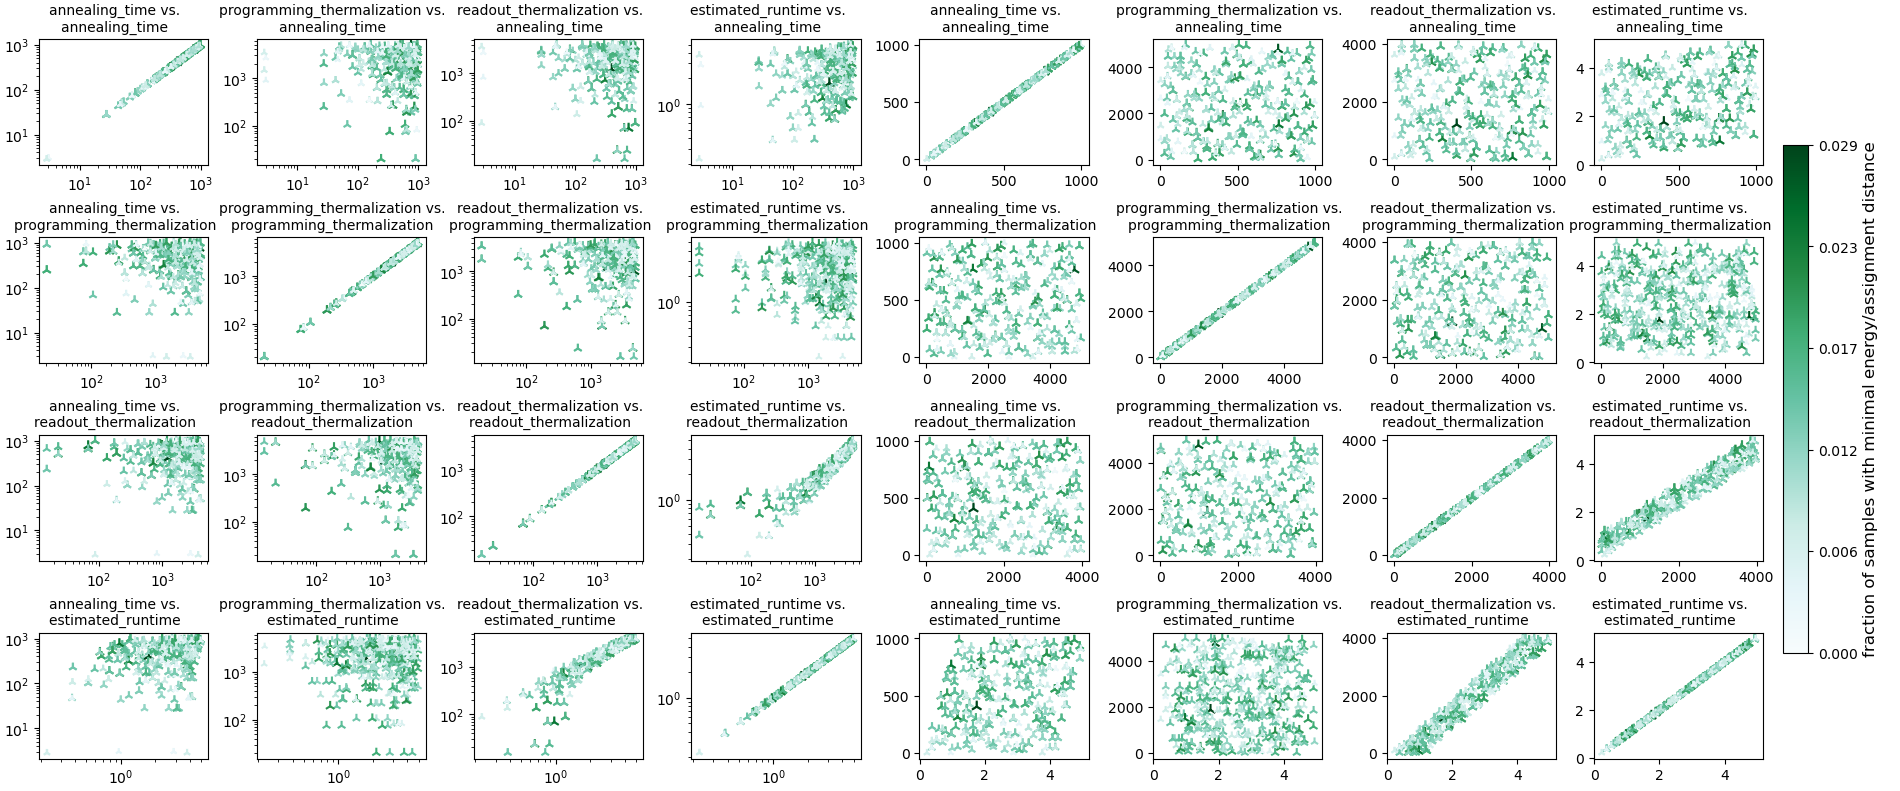

In [52]:
print(results_names)
print(mean.shape) if np.array(mean).all() else print('GP was not trained')
print(colour_label)
print(dir_name_path_plots)
print(sampler_array.shape)
print(study_matched_started_ids.dtype)
print(study_matched_started_ids.ndim)
print(len(study_matched_started_ids['sets'].dtype.names))
print(study_matched_started_ids['sets'].ndim)
fig2, fig_pp1 = h5py_funcs.inspections.return_plots(study_name = study_name\
        , study_matched_started_ids = study_matched_started_ids\
        , gp_mean = mean, results_names = results_names, dict_info_read = dict_info_read\
        , sampler_array = sampler_array, colour_label = colour_label, dir_name_path_plots = dir_name_path_plots\
        , comb_types=['bi'], kwargs_pltrc=kwargs_pltrc)

In [53]:
plt.close()

No such comm: 84f0b9c1c01d4641a09d35cad755349e


In [54]:

fig_pp1.show()

In [55]:
import SALib as sa
import SALib.analyze.sobol

In [56]:
names = study_matched_started_ids['sets'].dtype.names[:3]
bounds = [[study_matched_started_ids['sets'][name].min(), study_matched_started_ids['sets'][name].max()] for name in names]
salib_problem = {
    'num_vars': 3,
    'names': names,
    'bounds': bounds
}
salib_problem

{'num_vars': 3,
 'names': ('annealing_time',
  'programming_thermalization',
  'readout_thermalization'),
 'bounds': [[2.8536251625046134, 998.14891469758],
  [20.36377787590027, 4980.655815452337],
  [15.417773276567459, 3975.9093448519707]]}

In [57]:
ar = sampler_array[:,-2]
sa.analyze.sobol.analyze(salib_problem, np.pad(ar, (0, 512-len(ar)), 'constant', constant_values=(0, ar.mean())), print_to_console=True)

                                  ST   ST_conf
annealing_time              0.588597  0.186335
programming_thermalization  0.528478  0.174597
readout_thermalization      0.691592  0.291896
                                  S1   S1_conf
annealing_time              0.105605  0.343836
programming_thermalization -0.268829  0.320748
readout_thermalization      0.110352  0.357340
                                                          S2   S2_conf
(annealing_time, programming_thermalization)        0.054723  0.424241
(annealing_time, readout_thermalization)           -0.306240  0.457228
(programming_thermalization, readout_thermaliza...  0.289930  0.419624


{'S1': array([ 0.1056046 , -0.26882898,  0.11035173]),
 'S1_conf': array([0.34383593, 0.32074773, 0.35733978]),
 'ST': array([0.58859663, 0.52847839, 0.69159179]),
 'ST_conf': array([0.18633547, 0.17459731, 0.29189589]),
 'S2': array([[        nan,  0.05472343, -0.3062401 ],
        [        nan,         nan,  0.28993004],
        [        nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.4242406 , 0.45722766],
        [       nan,        nan, 0.41962356],
        [       nan,        nan,        nan]])}

In [58]:
ar = sampler_array[:,-2]
ar2 = np.pad(ar, (0, 512-len(ar)), 'constant', constant_values=(0, 0))

In [62]:
sampler_array, names

(array([[1.00e+00, 1.00e+01, 1.57e+02, ..., 3.26e+02, 1.57e-02, 3.26e-02],
        [1.00e+00, 1.00e+01, 1.57e+02, ..., 3.31e+02, 1.57e-02, 3.31e-02],
        [1.00e+00, 1.00e+01, 1.46e+02, ..., 3.34e+02, 1.46e-02, 3.34e-02],
        ...,
        [1.00e+00, 1.00e+01, 1.44e+02, ..., 3.04e+02, 1.44e-02, 3.04e-02],
        [1.00e+00, 1.00e+01, 1.32e+02, ..., 2.78e+02, 1.32e-02, 2.78e-02],
        [1.00e+00, 1.00e+01, 1.45e+02, ..., 2.74e+02, 1.45e-02, 2.74e-02]]),
 ('annealing_time', 'programming_thermalization', 'readout_thermalization'))